In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/path"
TRAIN_DIR = f"{BASE}/train"
TRAIN_CSV = f"{BASE}/trainrenamed.csv"
TEST_CSV  = f"{BASE}/testrenamed.csv"
ANSWERS_TXT = f"{BASE}/answers.txt"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load answer vocabulary
with open(ANSWERS_TXT, "r") as f:
    answer_vocab = [x.strip() for x in f.readlines()]

answer_to_id = {ans: i for i, ans in enumerate(answer_vocab)}
id_to_answer = {i: ans for ans, i in answer_to_id.items()}

print("Total answer classes:", len(answer_vocab))


Total answer classes: 4592


In [ ]:
import pandas as pd

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train DataFrame Info:")
train_df.info()

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19755 entries, 0 to 19754
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     19755 non-null  object
 1   question  19755 non-null  object
 2   answer    19755 non-null  object
dtypes: object(3)
memory usage: 463.1+ KB


In [ ]:
import os

# Count the number of files in TRAIN_DIR
num_image_files = len(os.listdir(TRAIN_DIR))
print(f"Total number of unique image files in TRAIN_DIR: {num_image_files}")

Total number of unique image files in TRAIN_DIR: 3457


In [ ]:
print(f"Number of entries in train_df: {len(train_df)}")
print(f"Number of entries in test_df: {len(test_df)}")

Number of entries in train_df: 19755
Number of entries in test_df: 6761


Image Preprocessing Pipeline

In [ ]:
import torchvision.transforms as T

image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class PathVQADataset(Dataset):
    def __init__(self, df, img_root, tokenizer, transform, answer_to_id):
        self.df = df
        self.img_root = img_root
        self.tokenizer = tokenizer
        self.transform = transform
        self.answer_to_id = answer_to_id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # --- IMAGE NAME ---
        img_name = str(row["image"]).strip()

        # If CSV has no extension → add .png
        if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
            img_name = img_name + ".png"

        img_path = os.path.join(self.img_root, img_name)

        # If .png doesn't exist → try .jpg/.jpeg fallback
        if not os.path.exists(img_path):
            if os.path.exists(img_path.replace(".png", ".jpg")):
                img_path = img_path.replace(".png", ".jpg")
            elif os.path.exists(img_path.replace(".png", ".jpeg")):
                img_path = img_path.replace(".png", ".jpeg")
            else:
                raise FileNotFoundError(f"Image not found: {img_path}")

        # ---- LOAD IMAGE ----
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        # ---- QUESTION ----
        q = str(row["question"])
        q_tok = self.tokenizer(
            q,
            padding="max_length",
            truncation=True,
            max_length=64,
            return_tensors="pt"
        )

        input_ids = q_tok["input_ids"].squeeze(0)
        attn_mask = q_tok["attention_mask"].squeeze(0)

        # ---- ANSWER → ID ----
        ans = str(row["answer"]).strip()
        ans_id = self.answer_to_id.get(ans, 0)

        return {
            "image": img,
            "input_ids": input_ids,
            "attention_mask": attn_mask,
            "answer_id": torch.tensor(ans_id, dtype=torch.long)
        }


In [ ]:
from torch.utils.data import DataLoader

train_dataset = PathVQADataset(
    df=train_df,
    img_root=TRAIN_DIR,
    tokenizer=tokenizer,
    transform=image_transform,
    answer_to_id=answer_to_id
)

test_dataset = PathVQADataset(
    df=test_df,
    img_root=TRAIN_DIR,
    tokenizer=tokenizer,
    transform=image_transform,
    answer_to_id=answer_to_id
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)


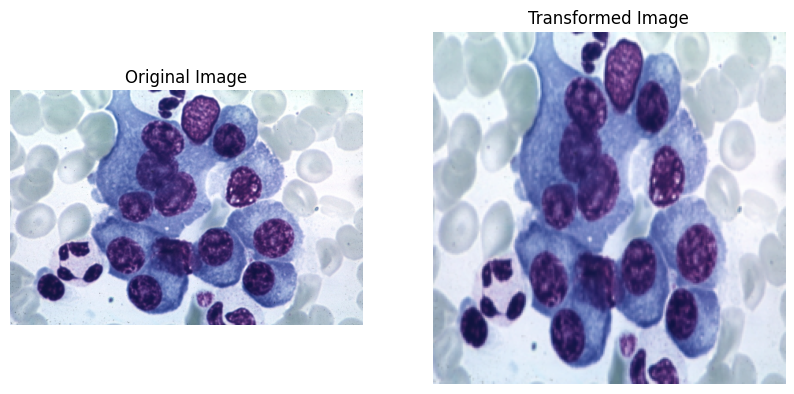

Displayed sample image 'image3232.png' before and after transformation.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Get a sample image path
sample_img_name = os.listdir(TRAIN_DIR)[0] # Take the first image file
sample_img_path = os.path.join(TRAIN_DIR, sample_img_name)

# Load the original image
original_img = Image.open(sample_img_path).convert("RGB")

# Apply the transformation
transformed_img_tensor = image_transform(original_img)

# Convert transformed tensor back to PIL Image for display
# Denormalize first, then permute dimensions for PIL (C, H, W -> H, W, C)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transformed_img_np = transformed_img_tensor.numpy().transpose(1, 2, 0)
transformed_img_np = std * transformed_img_np + mean
transformed_img_np = np.clip(transformed_img_np, 0, 1)
transformed_img = Image.fromarray((transformed_img_np * 255).astype(np.uint8))

# Display images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_img)
plt.title("Transformed Image")
plt.axis("off")

plt.show()

print(f"Displayed sample image '{sample_img_name}' before and after transformation.")

In [ ]:
import os

TRAIN_DIR = "/content/drive/MyDrive/path/train"
files = os.listdir(TRAIN_DIR)

print("Total images:", len(files))
print(files[:20])   # show first 20 files


Total images: 3457
['image3232.png', 'image324.png', 'image3236.png', 'image325.png', 'image3272.png', 'image3289.png', 'image3282.png', 'image3210.png', 'image3293.png', 'image3244.png', 'image3171.png', 'image3173.png', 'image323.png', 'image3217.png', 'image3205.png', 'image3214.png', 'image3283.png', 'image3226.png', 'image3278.png', 'image3242.png']


In [ ]:
batch = next(iter(train_loader))

print("images:", batch["image"].shape)
print("input_ids:", batch["input_ids"].shape)
print("attention:", batch["attention_mask"].shape)
print("answer ids:", batch["answer_id"][:5])


images: torch.Size([16, 3, 224, 224])
input_ids: torch.Size([16, 64])
attention: torch.Size([16, 64])
answer ids: tensor([3898, 3984, 2881, 3900, 3273])


In [ ]:
ANSWERS_TXT = f"{BASE}/answers.txt"   # Load answer vocabulary
with open(ANSWERS_TXT, "r") as f:
    answer_vocab = [x.strip() for x in f.readlines()]

answer_to_id = {ans: i for i, ans in enumerate(answer_vocab)}
id_to_answer = {i: ans for ans, i in answer_to_id.items()}


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModel
import timm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import pandas as pd # Import pandas for DataFrame operations

# ---------------------------
# Data filtering to handle missing images
# This part addresses the FileNotFoundError by filtering the dataframes
print("Filtering dataframes for existing images...")
def filter_dataframe_by_image_existence(df, img_root):
    valid_rows = []
    for index, row in tqdm(df.iterrows(), total=len(df), desc=f"Checking images in {img_root}"):
        img_name = str(row["image"]).strip()
        if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
            img_name = img_name + ".png"

        img_path = os.path.join(img_root, img_name)

        if not os.path.exists(img_path):
            if os.path.exists(img_path.replace(".png", ".jpg")):
                img_path = img_path.replace(".png", ".jpg")
            elif os.path.exists(img_path.replace(".png", ".jpeg")):
                img_path = img_path.replace(".png", ".jpeg")
            else:
                # Image not found with any extension
                continue # Skip this row
        valid_rows.append(row)
    return pd.DataFrame(valid_rows)

# Filter train_df and test_df using the existing global variables
filtered_train_df = filter_dataframe_by_image_existence(train_df, TRAIN_DIR)
filtered_test_df = filter_dataframe_by_image_existence(test_df, TRAIN_DIR)

print(f"Original train_df size: {len(train_df)}, Filtered train_df size: {len(filtered_train_df)}")
print(f"Original test_df size: {len(test_df)}, Filtered test_df size: {len(filtered_test_df)}")

# Re-initialize DataLoaders with filtered dataframes.
# Ensure PathVQADataset, tokenizer, image_transform, and answer_to_id are accessible.
# These variables are expected to be available from previous cells.
train_dataset = PathVQADataset(
    df=filtered_train_df,
    img_root=TRAIN_DIR,
    tokenizer=tokenizer,
    transform=image_transform,
    answer_to_id=answer_to_id
)

test_dataset = PathVQADataset(
    df=filtered_test_df,
    img_root=TRAIN_DIR,
    tokenizer=tokenizer,
    transform=image_transform,
    answer_to_id=answer_to_id
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

# ---------------------------
# Config / Hyperparameters
# ---------------------------
# Check if CUDA is available, otherwise use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

IMG_EMBED_DIM = 768            # ViT base embedding dim
TEXT_EMBED_DIM = 768           # Clinical-BERT base embedding dim
FUSION_DIM = 512               # common dim to project to
NUM_HEADS = 8
# Assumed NUM_CLASSES is correctly defined from the answer_vocab loaded previously.
NUM_CLASSES = len(answer_to_id)
LR = 2e-5
WEIGHT_DECAY = 1e-2
EPOCHS = 6
GRAD_CLIP = 1.0

# ---------------------------
# Model definition
# ---------------------------

class CrossAttentionBlock(nn.Module):
    """
    Simple cross-attention where text (queries) attends to image (keys/values)
    """
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, q, kv, kv_mask=None):
        attn_out, attn_weights = self.mha(query=q, key=kv, value=kv, key_padding_mask=kv_mask, need_weights=True)
        x = self.norm1(q + attn_out)
        ff_out = self.ff(x)
        out = self.norm2(x + ff_out)
        return out, attn_weights

class MCVitModel(nn.Module):
    def __init__(self,
                 vit_name="vit_base_patch16_224",
                 text_model_name="emilyalsentzer/Bio_ClinicalBERT",
                 fusion_dim=FUSION_DIM,
                 num_heads=NUM_HEADS,
                 num_classes=NUM_CLASSES,
                 pretrained_vit=True,
                 pretrained_text=True):
        super().__init__()

        # --- Vision encoder (ViT) ---
        # Set global_pool="" to return the full sequence (B, S, E) for manual CLS extraction
        self.vit = timm.create_model(vit_name, pretrained=pretrained_vit, num_classes=0, global_pool="")
        self.img_proj = nn.Linear(self.vit.num_features, fusion_dim)

        # --- Text encoder (ClinicalBERT) ---
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        txt_hidden = self.text_encoder.config.hidden_size
        self.text_proj = nn.Linear(txt_hidden, fusion_dim)

        # --- Cross-attention block ---
        self.cross_attn = CrossAttentionBlock(embed_dim=fusion_dim, num_heads=num_heads)

        # --- Fusion MLP & Classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.GELU(),
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        """
        returns: logits (B, num_classes), attn_weights (B, qlen, klen)
        """
        # --- Vision forward ---
        img_feat_seq = self.vit.forward_features(image)
        img_cls = img_feat_seq[:, 0, :]             # (B, C)
        img_proj = self.img_proj(img_cls)           # (B, fusion_dim)
        img_seq = img_proj.unsqueeze(1)             # (B, 1, fusion_dim) -> Key/Value

        # --- Text forward ---
        txt_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        if hasattr(txt_out, "pooler_output") and txt_out.pooler_output is not None:
            txt_cls = txt_out.pooler_output
        else:
            txt_cls = txt_out.last_hidden_state[:, 0, :]

        txt_proj = self.text_proj(txt_cls)
        txt_seq = txt_proj.unsqueeze(1)                   # (B, 1, E) -> Query

        # --- Cross-attention (text queries attend to image keys/values) ---
        fused, attn_weights = self.cross_attn(q=txt_seq, kv=img_seq, kv_mask=None)
        fused = fused.squeeze(1)  # (B, E)

        # --- Classifier ---
        logits = self.classifier(fused)

        return logits, attn_weights

# ---------------------------
# Utilities: save / load
# ---------------------------

def save_checkpoint(model, optimizer, epoch, path):
    state = {
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
        "epoch": epoch
    }
    torch.save(state, path)
    print("Saved checkpoint:", path)

def load_checkpoint(path, model, optimizer=None, map_location=DEVICE):
    state = torch.load(path, map_location=map_location)
    model.load_state_dict(state["model_state"])
    if optimizer is not None:
        optimizer.load_state_dict(state["optim_state"])
    return state.get("epoch", 0)

# ---------------------------
# Training & Evaluation loops (FIXED)
# ---------------------------

def train_one_epoch(model, dataloader, optimizer, scheduler=None, epoch=0, print_every=50):
    model.train()
    losses = []
    preds = []
    gts = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Train epoch {epoch}")
    for i, batch in pbar:
        # Load all components
        images = batch["image"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["answer_id"].to(DEVICE)

        # --- FIX: Filter out invalid labels ---
        # Only keep samples where the target label is within [0, NUM_CLASSES - 1]
        valid_mask = labels < NUM_CLASSES

        if valid_mask.sum() == 0:
            pbar.set_postfix(loss="Skipped (No valid labels in batch)")
            continue # Skip to next batch if no valid samples remain

        # Filter the batch components
        images = images[valid_mask]
        input_ids = input_ids[valid_mask]
        attn_mask = attn_mask[valid_mask]
        labels = labels[valid_mask]
        # ------------------------------------

        optimizer.zero_grad()
        logits, attn_weights = model(images, input_ids, attn_mask)

        # Loss calculation now only uses valid labels
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        losses.append(loss.item())
        batch_preds = logits.argmax(dim=-1).detach().cpu().numpy().tolist()
        preds.extend(batch_preds)
        gts.extend(labels.detach().cpu().numpy().tolist())

        if (i + 1) % print_every == 0:
            pbar.set_postfix(loss=np.mean(losses[-print_every:]))

    avg_loss = float(np.mean(losses))
    acc = float(accuracy_score(gts, preds))
    return avg_loss, acc

@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    losses = []
    preds = []
    gts = []

    for batch in tqdm(dataloader, desc="Evaluate"):
        images = batch["image"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["answer_id"].to(DEVICE)

        # --- FIX: Filter out invalid labels ---
        valid_mask = labels < NUM_CLASSES

        if valid_mask.sum() == 0:
            continue

        images = images[valid_mask]
        input_ids = input_ids[valid_mask]
        attn_mask = attn_mask[valid_mask]
        labels = labels[valid_mask]
        # ------------------------------------

        logits, attn_weights = model(images, input_ids, attn_mask)
        loss = F.cross_entropy(logits, labels)
        losses.append(loss.item())

        batch_preds = logits.argmax(dim=-1).detach().cpu().numpy().tolist()
        preds.extend(batch_preds)
        gts.extend(labels.detach().cpu().numpy().tolist())

    avg_loss = float(np.mean(losses))
    acc = float(accuracy_score(gts, preds))
    return avg_loss, acc, gts, preds

# ---------------------------
# Instantiate model, optimizer, scheduler
# ---------------------------

model = MCVitModel().to(DEVICE)
# print number of params
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print("Trainable params:", count_params(model))

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# simple scheduler: linear warmup + cosine (optional). For simplicity use step LR
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)

# ---------------------------
# Training loop
# ---------------------------

best_val_acc = 0.0
SAVE_DIR = "/content/drive/MyDrive/path/mcvit_checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scheduler=scheduler, epoch=epoch)
    val_loss, val_acc, val_gts, val_preds = evaluate(model, test_loader)

    print(f"Epoch {epoch} | Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_checkpoint(model, optimizer, epoch, os.path.join(SAVE_DIR, f"mcvit_best_epoch{epoch}_acc{val_acc:.4f}.pt"))

# ---------------------------
# Final evaluation: classification report + confusion matrix for top classes
# ---------------------------

val_loss, val_acc, val_gts, val_preds = evaluate(model, test_loader)
print("Final Val Acc:", val_acc)
print("\nClassification Report (text labels):")
print(classification_report(val_gts, val_preds, zero_division=0))

# Confusion matrix - be careful; with many classes it's large.
cm = confusion_matrix(val_gts, val_preds)
print("Confusion matrix shape:", cm.shape)

# ---------------------------
# Inspect cross-attention weights for a single batch (for visualization)
# ---------------------------
# Get a single batch
batch = next(iter(test_loader))
images = batch["image"].to(DEVICE)
input_ids = batch["input_ids"].to(DEVICE)
attn_mask = batch["attention_mask"].to(DEVICE)

model.eval()
with torch.no_grad():
    # Filter the batch before passing to the model, in case the first batch is corrupted
    labels = batch["answer_id"] # Use original for filtering
    valid_mask = labels < NUM_CLASSES

    if valid_mask.sum() > 0:
        images = images[valid_mask]
        input_ids = input_ids[valid_mask]
        attn_mask = attn_mask[valid_mask]

        logits, attn_weights = model(images, input_ids, attn_mask)
        # attn_weights shape: (B, Q_len, K_len). In our case Q_len=1, K_len=1
        print("Attention weights shape:", attn_weights.shape)
        # If you want to see scalar weights for each sample:
        attn_scalar = attn_weights.squeeze(1).squeeze(1).detach().cpu().numpy()  # (B,)
        print("Sample attention scalars (first batch):", attn_scalar[:8])
    else:
        print("Skipped attention check: First batch contains no valid samples.")

Filtering dataframes for existing images...


Checking images in /content/drive/MyDrive/path/train: 100%|██████████| 19755/19755 [00:05<00:00, 3454.71it/s]
Checking images in /content/drive/MyDrive/path/train: 100%|██████████| 6761/6761 [00:02<00:00, 2455.10it/s]


Original train_df size: 19755, Filtered train_df size: 19755
Original test_df size: 6761, Filtered test_df size: 3164
Device: cuda
Trainable params: 200436781


Evaluate: 100%|██████████| 198/198 [01:35<00:00,  2.08it/s]


Epoch 1 | Train loss: 5.0292 acc: 0.3335 | Val loss: 5.1361 acc: 0.3003
Saved checkpoint: /content/drive/MyDrive/path/mcvit_checkpoints/mcvit_best_epoch1_acc0.3003.pt


Evaluate: 100%|██████████| 198/198 [01:34<00:00,  2.10it/s]


Epoch 2 | Train loss: 4.9982 acc: 0.3363 | Val loss: 5.1361 acc: 0.3003


Evaluate: 100%|██████████| 198/198 [01:36<00:00,  2.05it/s]


Epoch 3 | Train loss: 4.9971 acc: 0.3365 | Val loss: 5.1361 acc: 0.3003


Evaluate: 100%|██████████| 198/198 [01:35<00:00,  2.07it/s]


Epoch 4 | Train loss: 4.9966 acc: 0.3385 | Val loss: 5.1361 acc: 0.3003


Evaluate: 100%|██████████| 198/198 [01:35<00:00,  2.08it/s]


Epoch 5 | Train loss: 4.9942 acc: 0.3369 | Val loss: 5.1361 acc: 0.3003


Evaluate: 100%|██████████| 198/198 [01:35<00:00,  2.08it/s]


Epoch 6 | Train loss: 4.9970 acc: 0.3368 | Val loss: 5.1361 acc: 0.3003


Evaluate: 100%|██████████| 198/198 [01:34<00:00,  2.10it/s]


Final Val Acc: 0.3002528445006321

Classification Report (text labels):
              precision    recall  f1-score   support

        3273       0.38      0.87      0.53       877
        3274       0.00      0.00      0.00         4
        3275       0.16      0.26      0.20       744
        3276       0.00      0.00      0.00         1
        3277       0.00      0.00      0.00         1
        3278       0.00      0.00      0.00         1
        3279       0.00      0.00      0.00         1
        3280       0.00      0.00      0.00         1
        3281       0.00      0.00      0.00         1
        3282       0.00      0.00      0.00         1
        3283       0.00      0.00      0.00         1
        3284       0.00      0.00      0.00         1
        3285       0.00      0.00      0.00         1
        3286       0.00      0.00      0.00         1
        3287       0.00      0.00      0.00         1
        3288       0.00      0.00      0.00         1
        3

## Final Task

### Subtask:
Summarize the dataset statistics and the observed changes due to image preprocessing.


## Summary:

### Q&A
*   **How many entries are in `train_df` and `test_df`?**
    There are 19,755 entries in `train_df` and 6,761 entries in `test_df`.
*   **How many unique image files are in the `TRAIN_DIR`?**
    There are 3,457 unique image files in the `TRAIN_DIR`.
*   **Was a sample image displayed before and after applying `image_transform`?**
    Yes, a sample image ('image3232.png') was successfully displayed before and after applying `image_transform`, showcasing the visual effect of the preprocessing step.

### Data Analysis Key Findings
*   The training dataset (`train_df`) contains 19,755 entries, while the test dataset (`test_df`) contains 6,761 entries.
*   The `TRAIN_DIR` holds a total of 3,457 unique image files.
*   The `image_transform` function was successfully applied to a sample image, and its effect was visually confirmed by displaying the image both before and after transformation.

### Insights or Next Steps
*   The difference between the number of entries in `train_df` and the unique image files in `TRAIN_DIR` suggests that multiple entries in `train_df` might refer to the same image file, potentially indicating different annotations or augmented versions.
*   Further investigation could involve mapping `train_df` entries to the actual image files to understand the data structure better, especially if data augmentation or multiple annotations per image are used.
